In [1]:
!nvidia-smi

Mon Jun 22 21:38:36 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.59       Driver Version: 440.59       CUDA Version: 10.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  GeForce GTX 1080    Off  | 00000000:09:00.0 Off |                  N/A |
| 27%   37C    P0    47W / 180W |      0MiB /  8119MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [2]:
import os
import math
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.nn.utils as utils
import imageio
import warnings
import numpy as np
import astropy.stats as st
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt
import collections as col
from partial_conv import PartialConv2d

In [3]:
sns.set_style('white')
plt.rc("axes.spines", top=False, right=False)
plt.rcParams['figure.figsize'] = (8, 5)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [4]:
def get_n_params(model):
    trainable = filter(lambda x: x.requires_grad, model.parameters())
    n_params = sum([np.prod(p.size()) for p in trainable])
    return n_params

In [5]:
def get_gradient_norm(model):
    total_norm = 0
    for p in model.parameters():
        param_norm = p.grad.data.norm(2)
        total_norm += param_norm.item() ** 2
    return total_norm ** (0.5)

In [21]:
class SSTPatchDataset(torch.utils.data.Dataset):
    def __init__(self, filepath, normalize=True, norm_params=None, fill_value=-1):
        self.normalize = normalize
        self.fill_value = fill_value
        
        print("Creating dataset from file:", filepath)
        fields = np.load(filepath)['fields'].astype(np.float32)[:1]
        metadata = np.load(filepath, allow_pickle=True)['metadata'][:1]
        
        if normalize:
            mask = np.isnan(fields)
            if not norm_params:
                field_dropna = fields[~np.isnan(fields)]
                norm_params = (field_dropna.min(), field_dropna.max())
            fields = (fields - norm_params[0]) / (norm_params[1] - norm_params[0])
            fields[mask] = fill_value
    
        self.norm_params = norm_params
        self.fields = torch.from_numpy(fields)
        self.metadata = metadata
    
    def inverse_transform(self, x):
        if isinstance(x, torch.Tensor):
            x = x.detach().cpu().numpy()
        if self.normalize:
            x = x * (self.norm_params[1] - self.norm_params[0]) + self.norm_params[0]
        return x
        
    def __getitem__(self, i):
        field = self.fields[i][None, :, :]
        mask = (~(field == self.fill_value)).float()
        meta = self.metadata[i].tolist()
        return field, mask, meta
    
    def __len__(self):
        return self.fields.size(0)

In [7]:
def conv3x3(in_planes, out_planes, stride=1):
    return PartialConv2d(in_planes, out_planes, kernel_size=3, stride=stride,
                         padding=1, bias=False, multi_channel=True, return_mask=True)

In [8]:
class ResidualBlock(nn.Module):
    def __init__(self, inplanes, planes):
        super().__init__()
        self.conv1 = conv3x3(inplanes, planes)
        self.bn1 = nn.BatchNorm2d(planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(planes, planes)
        self.bn2 = nn.BatchNorm2d(planes)

    def forward(self, x, mask):
        residual = x
        residual_mask = mask

        out, mask = self.conv1(x, mask)
        out = self.bn1(out)
        out = self.relu(out)

        out, mask = self.conv2(out, mask)
        out = self.bn2(out)

        out += residual
        out = self.relu(out)
        
        mask = torch.logical_and(mask, residual_mask)

        return out, mask.float()

In [9]:
class EncoderLayer(nn.Module):
    def __init__(self, in_planes, out_planes, stride, blocks):
        super().__init__()
        self.conv = conv3x3(in_planes, out_planes, stride)
        self.bn = nn.BatchNorm2d(out_planes)
        self.relu = nn.ReLU(inplace=True)
        self.blocks = nn.ModuleList([ResidualBlock(out_planes, out_planes) for _ in range(blocks)])
        
    def forward(self, x, mask):
        x, mask = self.conv(x, mask)
        x = self.bn(x)
        x = self.relu(x)
        
        for b in self.blocks:
            x, mask = b(x, mask)

        return x, mask

In [10]:
class DecoderLayer(nn.Module):
    def __init__(self, in_planes, out_planes, upscale_factor, blocks):
        super().__init__()
        self.blocks = nn.ModuleList([ResidualBlock(in_planes, in_planes) for _ in range(blocks)])
        self.conv = conv3x3(in_planes, out_planes)
        self.upsample = nn.Upsample(scale_factor=upscale_factor)
        self.bn = nn.BatchNorm2d(out_planes)
        self.act = nn.ReLU(inplace=True)
        
    def forward(self, x, mask):
        for b in self.blocks:
            x, mask = b(x, mask)
        
        x, mask = self.conv(x, mask)
        x = self.upsample(x)
        mask = self.upsample(mask)
        x = self.bn(x)
        x = self.act(x)

        return x, mask

In [11]:
class AutoEncoder(nn.Module):
    def __init__(self, latent_dim=10, blocks_per_layer=0):
        super().__init__()
        
        self.encoder = nn.ModuleList([
            EncoderLayer(1, 32, 2, blocks_per_layer),
            EncoderLayer(32, 64, 2, blocks_per_layer),
            EncoderLayer(64, 128, 2, blocks_per_layer),
            EncoderLayer(128, 256, 2, blocks_per_layer),
            EncoderLayer(256, 512, 2, blocks_per_layer),
            EncoderLayer(512, 32, 1, blocks_per_layer)])

        self.decoder = nn.ModuleList([
            DecoderLayer(32, 512, 2, blocks_per_layer),
            DecoderLayer(512, 256, 2, blocks_per_layer),
            DecoderLayer(256, 128, 2, blocks_per_layer),
            DecoderLayer(128, 64, 2, blocks_per_layer),
            DecoderLayer(64, 32, 2, blocks_per_layer),
            DecoderLayer(32, 16, 1, blocks_per_layer)])
        
        self.out = conv3x3(16, 1)
        self.sigmoid = nn.Sigmoid()
    
    def _forward(self, x, mask):
        
        for layer in self.encoder:
            x, mask = layer(x, mask)
        
        z = x
        
        for layer in self.decoder:
            x, mask = layer(x, mask)
        
        x, mask = self.out(x, mask)
        
        return x, z
    
    def forward(self, x, mask):
        rx, _ = self._forward(x, mask)
        loss = ((x - rx) * mask).abs().sum() / mask.sum()
        return loss

In [22]:
train_dset = SSTPatchDataset('./data/processed/MODIS_night_data.npz')
train_loader = torch.utils.data.DataLoader(train_dset, batch_size=1, drop_last=True, shuffle=True, num_workers=8)

Creating dataset from file: ./data/processed/MODIS_night_data.npz


In [28]:
field, mask, meta = next(iter(train_loader))

In [29]:
field.shape, mask.shape

(torch.Size([1, 1, 96, 96]), torch.Size([1, 1, 96, 96]))

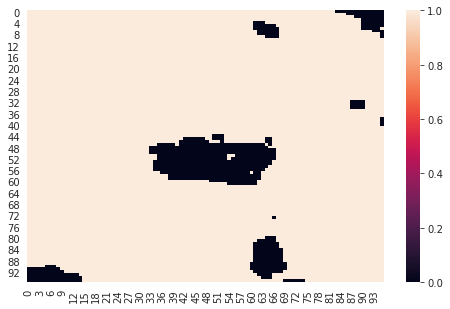

In [30]:
sns.heatmap(mask[0, 0].detach().cpu().numpy())

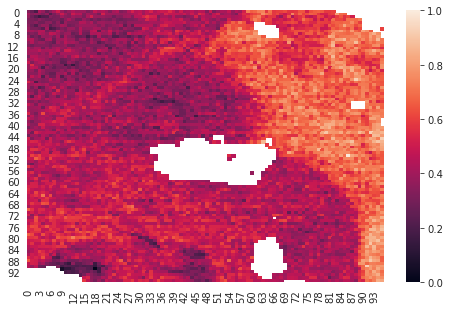

In [31]:
f = field[0, 0].detach().cpu().numpy()
sns.heatmap(f, mask=(f == -1))

In [36]:
model = AutoEncoder(blocks_per_layer=0).to(device)
print(f"There are {get_n_params(model):,d} parameters in this model.")
optimizer = torch.optim.AdamW(model.parameters(), lr=2.5e-3)

There are 3,437,456 parameters in this model.


In [37]:
global_step = 0
n_epochs = 20000
summary_interval = 10
eval_interval = 100
best_eval_loss = np.inf
best_recon_loss = np.inf
metrics = col.defaultdict(list)

In [41]:
field[field!=-1].min()

tensor(0., device='cuda:0')

In [38]:
try:
    total_loss = 0
    for epoch in range(n_epochs):
        for field, mask, meta in train_loader:
            field, mask = field.to(device), mask.to(device)
            optimizer.zero_grad()
            loss = model(field, mask)
            total_loss += loss.item()
            loss.backward()
#             utils.clip_grad_norm_(model.parameters(), 0.5)
            optimizer.step()
            global_step += 1
        
            if global_step % summary_interval == 0:
                current_loss = float(total_loss) / summary_interval
                print(f"Loss: {current_loss:.5f} | "
                     f"Gradient norm: {get_gradient_norm(model):.3f}")
                total_loss = 0

except KeyboardInterrupt:
    pass

Loss: 0.18246 | Gradient norm: 0.630
Loss: 0.06456 | Gradient norm: 0.235
Loss: 0.05799 | Gradient norm: 0.118
Loss: 0.05537 | Gradient norm: 0.080
Loss: 0.05403 | Gradient norm: 0.063
Loss: 0.05298 | Gradient norm: 0.114
Loss: 0.05221 | Gradient norm: 0.103


Exception ignored in: <function _releaseLock at 0x7f3a99cdb950>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/logging/__init__.py", line 221, in _releaseLock
    def _releaseLock():
KeyboardInterrupt


RuntimeError: DataLoader worker (pid(s) 23901) exited unexpectedly

In [20]:
field, mask, _ = next(iter(train_loader))
field, mask = field.to(device), mask.to(device)

In [36]:
rx, z = model._forward(field, mask)

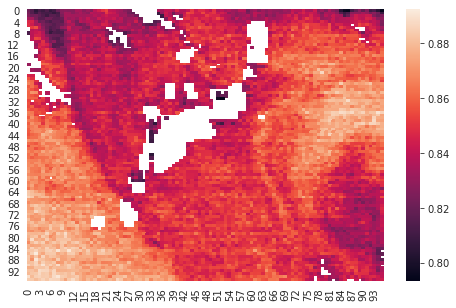

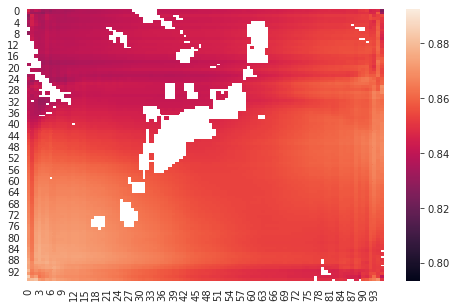

In [45]:
idx = np.random.choice(rx.size(0))
f = field[idx, 0].detach().cpu().numpy()
rf = rx[idx, 0].detach().cpu().numpy()
m = mask[idx, 0].detach().cpu().numpy()
m = (f == -1)
fill = np.mean(f[f != -1])
f[m] = fill
rf[m] = fill
vmin = f[f != -1].min()
vmax = f[f != -1].max()
sns.heatmap(f, mask=m, vmin=vmin, vmax=vmax)
plt.show()
sns.heatmap(rf, mask=m, vmin=vmin, vmax=vmax)
plt.show()

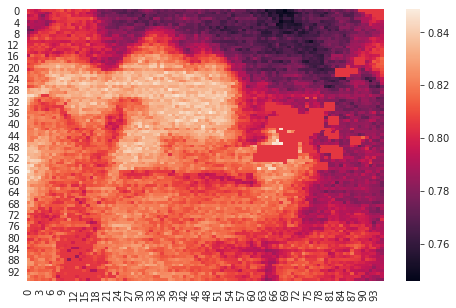

In [52]:
idx = np.random.choice(rx.size(0))
f = field[idx, 0].detach().cpu().numpy()
rf = rx[idx, 0].detach().cpu().numpy()
mask = (f == -1)
fill = np.mean(f[f != -1])
f[mask] = fill
rf[mask] = fill
sns.heatmap(f)

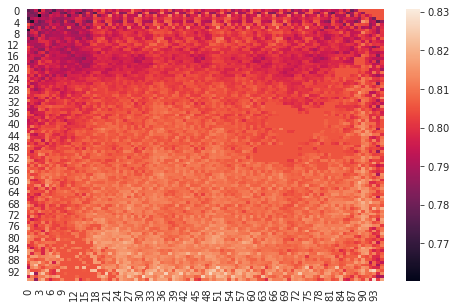

In [53]:
sns.heatmap(rf)

In [25]:
rx.shape

torch.Size([128, 1, 96, 96])

In [36]:
field.shape

torch.Size([128, 9216])

In [37]:
model.parameters()

<generator object Module.parameters at 0x7f55efff8b50>

In [40]:
model.encoder

AttributeError: 'Sequential' object has no attribute 'grad'